In [2]:
import pandas as pd

# --- Load parquet file ---
df = pd.read_parquet("../data/03_primary/mt_patients_validated.parquet")

def has_cols(d, cols):
    return all(c in d.columns for c in cols)



In [8]:
def has_cols(d, cols):
    return all(c in d.columns for c in cols)

def show(df_subset, n=10):
    if len(df_subset) == 0:
        print("No rows.")
        return
    display(df_subset.head(n))

def save_csv(df_subset, path):
    if len(df_subset) > 0:
        df_subset.to_csv(path, index=False)
        print(f"Saved -> {path} ({len(df_subset)} rows)")
    else:
        print("Nothing to save.")

# a small highlighter for negative/violating deltas
def highlight_negative(s):
    return ["background-color: #ffd6d6" if (isinstance(v, (int,float,np.floating)) and v < 0) else "" for v in s]


Violation A count: 0
No rows.
Nothing to save.


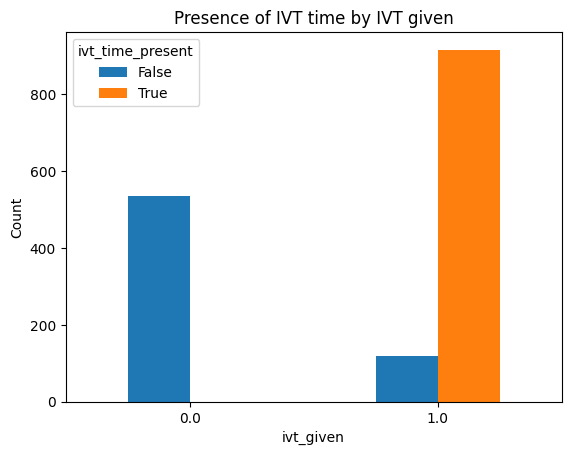

In [9]:
cols = ["patient_id", "ivt_given", "onset_to_ivt_min", "onset_time"]
if has_cols(df, cols):
    a_mask = df["ivt_given"].isin([0.0, 0]) & df["onset_to_ivt_min"].notna()
    vA = df.loc[a_mask, cols].sort_values("onset_to_ivt_min")
    print(f"Violation A count: {len(vA)}")
    show(vA, 20)
    save_csv(vA, "data/08_reporting/violations_ivt_time_present_despite_no_ivt.csv")

    # quick bar of counts for context
    ax = (df.assign(ivt_time_present=df["onset_to_ivt_min"].notna())
            .groupby(["ivt_given","ivt_time_present"]).size().unstack(fill_value=0)
            .plot(kind="bar", rot=0))
    ax.set_title("Presence of IVT time by IVT given")
    ax.set_ylabel("Count")
    plt.show()
else:
    print("Needed columns missing for Violation A:", cols)


Violation B count: 5


,patient_id,onset_to_ivt_min,onset_to_puncture_min,delta_ivt_minus_puncture
469,1117,198.0,105.0,93.0
837,749,80.0,50.0,30.0
378,1209,125.0,110.0,15.0
1023,562,115.0,100.0,15.0
723,863,109.0,105.0,4.0


Saved -> ../data/08_reporting/violations_ivt_gt_puncture.csv (5 rows)


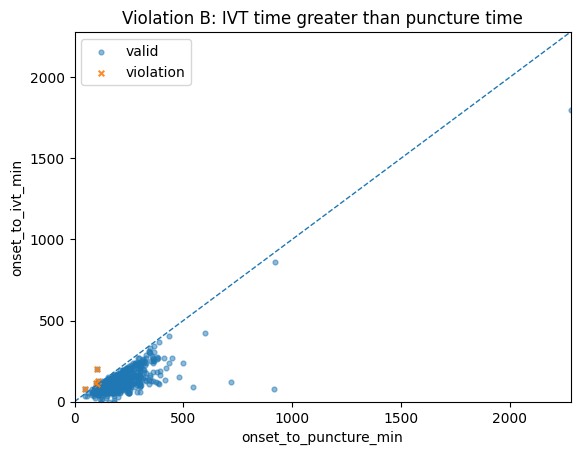

In [11]:
cols = ["patient_id", "onset_to_ivt_min", "onset_to_puncture_min", "onset_time"]
if has_cols(df, cols):
    t = df[cols].dropna(subset=["onset_to_ivt_min","onset_to_puncture_min"]).copy()
    t["delta_ivt_minus_puncture"] = t["onset_to_ivt_min"] - t["onset_to_puncture_min"]
    vB = t.loc[t["delta_ivt_minus_puncture"] > 0]\
           .sort_values("delta_ivt_minus_puncture", ascending=False)
    print(f"Violation B count: {len(vB)}")
    show(vB[["patient_id","onset_to_ivt_min","onset_to_puncture_min","delta_ivt_minus_puncture"]], 20)
    save_csv(vB, "../data/08_reporting/violations_ivt_gt_puncture.csv")

    # scatter with 45-degree line; violators highlighted
    fig, ax = plt.subplots()
    ax.scatter(t["onset_to_puncture_min"], t["onset_to_ivt_min"], s=12, alpha=0.5, label="valid")
    viol = vB
    ax.scatter(viol["onset_to_puncture_min"], viol["onset_to_ivt_min"], s=16, alpha=0.9, label="violation", marker="x")
    lim = [
        min(t["onset_to_puncture_min"].min(), t["onset_to_ivt_min"].min()),
        max(t["onset_to_puncture_min"].max(), t["onset_to_ivt_min"].max())
    ]
    ax.plot(lim, lim, linestyle="--", linewidth=1)  # y=x line
    ax.set_xlim(lim); ax.set_ylim(lim)
    ax.set_xlabel("onset_to_puncture_min")
    ax.set_ylabel("onset_to_ivt_min")
    ax.set_title("Violation B: IVT time greater than puncture time")
    ax.legend()
    plt.show()

    # styled table (highlight negative after flipping sign for display)
    (vB.assign(delta_neg = -vB["delta_ivt_minus_puncture"])
       [["patient_id","onset_to_ivt_min","onset_to_puncture_min","delta_ivt_minus_puncture"]]
       .head(20)
       .style.apply(highlight_negative, subset=["delta_ivt_minus_puncture"]))
else:
    print("Needed columns missing for Violation B:", cols)


Violation C count: 25


,patient_id,onset_to_puncture_min,onset_to_recan_min,delta_puncture_minus_recan
1070,515,1000.0,30.0,970.0
1486,91,915.0,460.0,455.0
1063,522,450.0,20.0,430.0
1071,514,450.0,30.0,420.0
1067,518,370.0,50.0,320.0
1458,120,480.0,199.0,281.0
232,1355,313.0,50.0,263.0
1077,508,280.0,25.0,255.0
1112,473,180.0,0.0,180.0
1111,474,200.0,50.0,150.0


Saved -> ../data/08_reporting/violations_puncture_gt_recan.csv (25 rows)


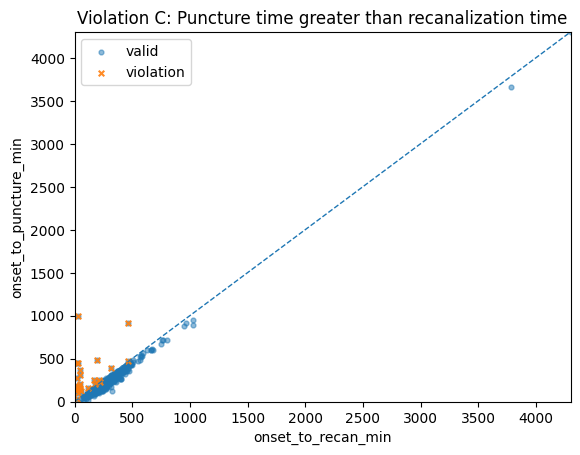

In [13]:
cols = ["patient_id", "onset_to_puncture_min", "onset_to_recan_min"]
if has_cols(df, cols):
    t = df[cols].dropna(subset=["onset_to_puncture_min","onset_to_recan_min"]).copy()
    t["delta_puncture_minus_recan"] = t["onset_to_puncture_min"] - t["onset_to_recan_min"]
    vC = t.loc[t["delta_puncture_minus_recan"] > 0]\
           .sort_values("delta_puncture_minus_recan", ascending=False)
    print(f"Violation C count: {len(vC)}")
    show(vC[["patient_id","onset_to_puncture_min","onset_to_recan_min","delta_puncture_minus_recan"]], 20)
    save_csv(vC, "../data/08_reporting/violations_puncture_gt_recan.csv")

    # scatter with y=x line; violators highlighted
    fig, ax = plt.subplots()
    ax.scatter(t["onset_to_recan_min"], t["onset_to_puncture_min"], s=12, alpha=0.5, label="valid")
    viol = vC
    ax.scatter(viol["onset_to_recan_min"], viol["onset_to_puncture_min"], s=16, alpha=0.9, label="violation", marker="x")
    lim = [
        min(t["onset_to_recan_min"].min(), t["onset_to_puncture_min"].min()),
        max(t["onset_to_recan_min"].max(), t["onset_to_puncture_min"].max())
    ]
    ax.plot(lim, lim, linestyle="--", linewidth=1)  # y=x
    ax.set_xlim(lim); ax.set_ylim(lim)
    ax.set_xlabel("onset_to_recan_min")
    ax.set_ylabel("onset_to_puncture_min")
    ax.set_title("Violation C: Puncture time greater than recanalization time")
    ax.legend()
    plt.show()

    # styled top rows
    (vC.head(20)
        .style.apply(highlight_negative, subset=["delta_puncture_minus_recan"]))
else:
    print("Needed columns missing for Violation C:", cols)


In [14]:
col = "patient_id"
if col in df.columns:
    dup_mask = df[col].duplicated(keep=False)
    vD = df.loc[dup_mask, [col, "onset_date", "onset_time"] + [c for c in df.columns if c not in [col, "onset_date","onset_time"]]]
    print(f"Violation D count (rows with duplicated patient_id): {len(vD)}")
    if len(vD):
        vD = vD.sort_values([col, "onset_date", "onset_time"])
        show(vD, 20)
        save_csv(vD, "data/08_reporting/violations_duplicate_patient_id.csv")

        # quick count per patient_id
        cnt = vD.groupby(col).size().sort_values(ascending=False)
        display(cnt.head(20).to_frame("row_count"))
    else:
        print("No duplicate patient_id rows.")
else:
    print("Needed column missing for Violation D:", col)


Violation D count (rows with duplicated patient_id): 0
No duplicate patient_id rows.


Violation E count (aspects > 10): 0


,patient_id,aspects,onset_date,onset_time


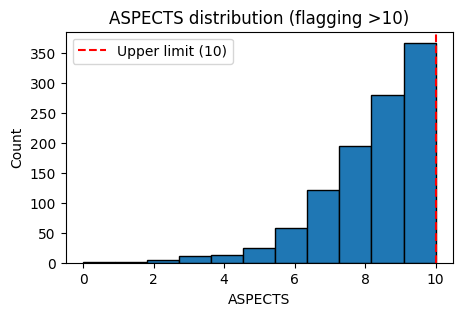

In [15]:
if "aspects" in df.columns:
    vE = df.loc[df["aspects"] > 10, ["patient_id", "aspects", "onset_date", "onset_time"]]
    print(f"Violation E count (aspects > 10): {len(vE)}")
    display(vE.head(20))
    if len(vE):
        vE.to_csv("../data/08_reporting/violations_aspects_gt10.csv", index=False)
        print("Saved -> ../data/08_reporting/violations_aspects_gt10.csv")

    # Quick histogram
    plt.figure(figsize=(5,3))
    plt.hist(df["aspects"].dropna(), bins=11, edgecolor="black")
    plt.axvline(10, color="r", linestyle="--", label="Upper limit (10)")
    plt.xlabel("ASPECTS")
    plt.ylabel("Count")
    plt.title("ASPECTS distribution (flagging >10)")
    plt.legend()
    plt.show()
else:
    print("Column 'aspects' not found.")


In [16]:
for col in ["nihss_admission", "nihss_24h", "nihss_7d"]:
    if col in df.columns:
        vF = df.loc[df[col] > 42, ["patient_id", col, "onset_date", "onset_time"]]
        print(f"\nViolation F count ({col} > 42): {len(vF)}")
        display(vF.head(20))
        if len(vF):
            path = f"data/08_reporting/violations_{col}_gt42.csv"
            vF.to_csv(path, index=False)
            print(f"Saved -> {path}")

        # Histogram
        plt.figure(figsize=(5,3))
        plt.hist(df[col].dropna(), bins=range(0,46,2), edgecolor="black")
        plt.axvline(42, color="r", linestyle="--", label="Upper limit (42)")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.title(f"{col} distribution (flagging >42)")
        plt.legend()
        plt.show()
    else:
        print(f"Column '{col}' not found.")


Column 'nihss_admission' not found.

Violation F count (nihss_24h > 42): 4


,patient_id,nihss_24h,onset_date,onset_time
823,763,99.0,2018-01-17,11:30
1342,240,43.0,2012-07-12,10:30
1521,56,43.0,2008-08-06,15:00
1524,53,43.0,2008-06-28,13:20


OSError: Cannot save file into a non-existent directory: 'data\08_reporting'

In [17]:
# E: aspects > 10
if "aspects" in df.columns:
    summary["aspects_gt10"] = int((df["aspects"] > 10).sum())

# F: any NIHSS > 42
for col in ["nihss_admission","nihss_24h","nihss_7d"]:
    if col in df.columns:
        summary[f"{col}_gt42"] = int((df[col] > 42).sum())

summary


NameError: name 'summary' is not defined

Violation E count (aspects > 10): 0


,patient_id,aspects,onset_date,onset_time


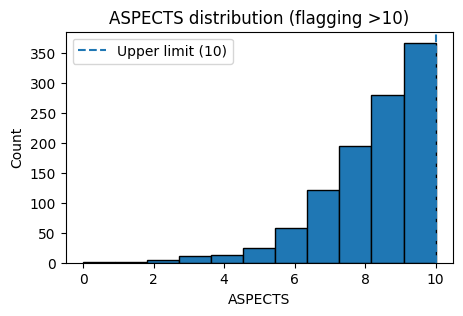

In [18]:
import matplotlib.pyplot as plt

if "aspects" in df.columns:
    vE = df.loc[df["aspects"] > 10, ["patient_id", "aspects", "onset_date", "onset_time"]]
    print(f"Violation E count (aspects > 10): {len(vE)}")
    display(vE.head(20))
    if len(vE):
        save_csv_safely(vE, "data/08_reporting/violations_aspects_gt10.csv")

    plt.figure(figsize=(5,3))
    plt.hist(df["aspects"].dropna(), bins=11, edgecolor="black")
    plt.axvline(10, linestyle="--", label="Upper limit (10)")
    plt.xlabel("ASPECTS"); plt.ylabel("Count"); plt.title("ASPECTS distribution (flagging >10)")
    plt.legend(); plt.show()


In [19]:
for col in ["nihss_admission","nihss_24h","nihss_7d"]:
    if col in df.columns:
        vF = df.loc[df[col] > 42, ["patient_id", col, "onset_date", "onset_time"]]
        print(f"\nViolation F count ({col} > 42): {len(vF)}")
        display(vF.head(20))
        if len(vF):
            save_csv_safely(vF, f"data/08_reporting/violations_{col}_gt42.csv")

        plt.figure(figsize=(5,3))
        plt.hist(df[col].dropna(), bins=range(0,46,2), edgecolor="black")
        plt.axvline(42, linestyle="--", label="Upper limit (42)")
        plt.xlabel(col); plt.ylabel("Count"); plt.title(f"{col} distribution (flagging >42)")
        plt.legend(); plt.show()



Violation F count (nihss_24h > 42): 4


,patient_id,nihss_24h,onset_date,onset_time
823,763,99.0,2018-01-17,11:30
1342,240,43.0,2012-07-12,10:30
1521,56,43.0,2008-08-06,15:00
1524,53,43.0,2008-06-28,13:20


NameError: name 'save_csv_safely' is not defined


=== onset_to_ivt_min > onset_to_puncture_min ===
Violations: 5  (0.6% of comparable rows)


,patient_id,onset_to_ivt_min,onset_to_puncture_min,onset_date,onset_time
378,1209,125.0,110.0,2022-02-11,8:45
469,1117,198.0,105.0,2021-01-05,08:30
723,863,109.0,105.0,2018-10-24,17:20
837,749,80.0,50.0,2017-12-28,6:00
1023,562,115.0,100.0,2016-08-28,19:30


Saved -> data\08_reporting\violations_onset_to_ivt_min_gt_onset_to_puncture_min.csv


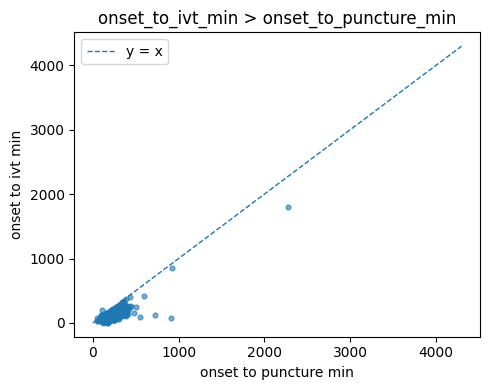


=== onset_to_puncture_min > onset_to_recan_min ===
Violations: 25  (2.3% of comparable rows)


,patient_id,onset_to_puncture_min,onset_to_recan_min,onset_date,onset_time
30,1557,395.0,315.0,2025-07-21,14:30
91,1496,470.0,465.0,2025-01-05,20:00
92,1495,230.0,224.0,2025-01-02,None
232,1355,313.0,50.0,2023-08-15,6:00
260,1327,95.0,30.0,2023-06-01,10:00
593,993,250.0,165.0,2019-11-20,21:25
894,691,130.0,15.0,2017-08-08,05:00
1059,526,250.0,215.0,2016-06-01,12:00
1063,522,450.0,20.0,2016-05-22,06:15
1064,521,120.0,55.0,2016-05-17,12:00


Saved -> data\08_reporting\violations_onset_to_puncture_min_gt_onset_to_recan_min.csv


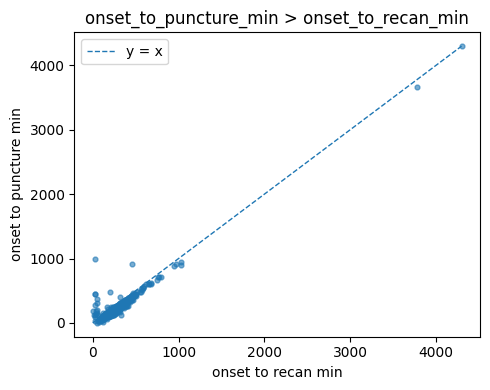


=== nihss_24h: values > 42 ===
Count: 4  (0.3% of non-missing)


,patient_id,nihss_24h,onset_date,onset_time
823,763,99.0,2018-01-17,11:30
1342,240,43.0,2012-07-12,10:30
1521,56,43.0,2008-08-06,15:00
1524,53,43.0,2008-06-28,13:20


Saved -> data\08_reporting\violations_nihss_24h_gt42.csv


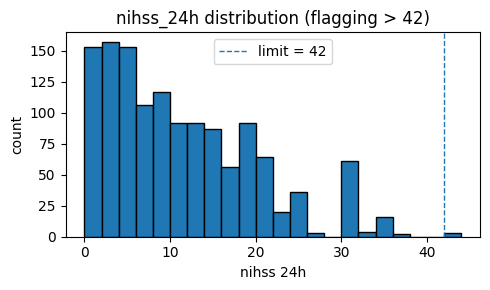


=== nihss_7d: values > 42 ===
Count: 72  (5.6% of non-missing)


,patient_id,nihss_7d,onset_date,onset_time
823,763,99.0,2018-01-17,11:30
834,752,43.0,2018-01-02,9:00
841,745,43.0,2017-12-22,9:00
842,744,43.0,2017-12-21,9:45
845,741,43.0,2017-12-14,14:00
866,720,43.0,2017-11-11,14:15
903,682,43.0,2017-07-13,10:45
911,674,43.0,2017-06-21,12
917,668,43.0,2017-06-01,7:30
931,654,43.0,2017-04-25,20:15


Saved -> data\08_reporting\violations_nihss_7d_gt42.csv


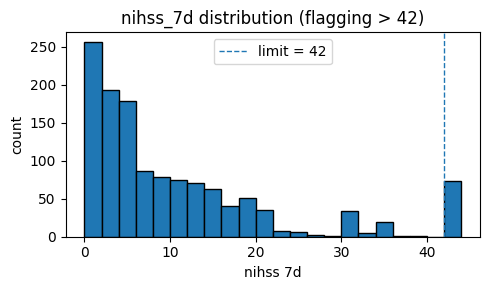

In [23]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# --- Load & prepare ---
df = pd.read_parquet(r"../data\02_intermediate\mt_patients_clean.parquet")

REPORT_DIR = Path("data/08_reporting")
REPORT_DIR.mkdir(parents=True, exist_ok=True)

def save_csv(df_, path):
    p = Path(path); p.parent.mkdir(parents=True, exist_ok=True)
    df_.to_csv(p, index=False)
    print(f"Saved -> {p}")

def show_list_and_plot_time_violation(xcol, ycol, title):
    """List rows where xcol > ycol and plot scatter vs y=x."""
    mask = df[xcol].notna() & df[ycol].notna() & (df[xcol] > df[ycol])
    bad = df.loc[mask, ["patient_id", xcol, ycol, "onset_date", "onset_time"]].copy()

    print(f"\n=== {title} ===")
    print(f"Violations: {len(bad)}  "
          f"({len(bad) / (df[xcol].notna() & df[ycol].notna()).sum():.1%} of comparable rows)")
    display(bad.head(20))
    if len(bad):
        out = REPORT_DIR / f"violations_{xcol}_gt_{ycol}.csv"
        save_csv(bad, out)

    # scatter
    plt.figure(figsize=(5,4))
    plt.scatter(df[ycol], df[xcol], s=12, alpha=0.6)
    lim = max(df[[xcol, ycol]].max(numeric_only=True))
    plt.plot([0, lim], [0, lim], linestyle="--", linewidth=1, label="y = x")
    plt.xlabel(ycol.replace("_", " "))
    plt.ylabel(xcol.replace("_", " "))
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


# --- Time-order violations ---
show_list_and_plot_time_violation(
    xcol="onset_to_ivt_min",
    ycol="onset_to_puncture_min",
    title="onset_to_ivt_min > onset_to_puncture_min"
)

show_list_and_plot_time_violation(
    xcol="onset_to_puncture_min",
    ycol="onset_to_recan_min",
    title="onset_to_puncture_min > onset_to_recan_min"
)

# --- NIHSS > 42 (admission/24h/7d) ---
for col in ["nihss_admission", "nihss_24h", "nihss_7d"]:
    if col not in df.columns:
        continue
    mask = df[col].notna() & (df[col] > 42)
    bad = df.loc[mask, ["patient_id", col, "onset_date", "onset_time"]].copy()

    print(f"\n=== {col}: values > 42 ===")
    print(f"Count: {len(bad)}  ({len(bad) / df[col].notna().sum():.1%} of non-missing)")
    display(bad.head(20))
    if len(bad):
        save_csv(bad, REPORT_DIR / f"violations_{col}_gt42.csv")

    # histogram
    plt.figure(figsize=(5,3))
    plt.hist(df[col].dropna(), bins=range(0, 46, 2), edgecolor="black")
    plt.axvline(42, linestyle="--", linewidth=1, label="limit = 42")
    plt.xlabel(col.replace("_"," "))
    plt.ylabel("count")
    plt.title(f"{col} distribution (flagging > 42)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [50]:
import pandas as pd

df = pd.read_parquet("../data/05_model_input/mt_lightgbm_ready.parquet")
df.head(23)


,patient_id,onset_date,onset_time,age,sex,aspects,occlusion_site,hemisphere,procedure,stent_combo,extraction_system,thrombolytics,procedure_duration,tici,ivt_given,ivt_different_hospital,transfer_from_other_hospital,iat_given,onset_to_ivt_min,onset_to_puncture_min,onset_to_recan_min,admission_nihss,nihss_24h,nihss_7d,sich,non_sich,mrs_before,mrs90,antithrombotics_before,statins_before,hypertension,diabetes,hyperlipidemia,smoking,alcohol_abuse,bmi,arrhythmia,tia_before,cmp_before,heart_condition,systolic_bp,diastolic_bp,glycemia,cholesterol,etiology,cerebral_edema,decompression_surgery,anesthesia,onset_year,age_missing,aspects_missing,onset_to_ivt_min_missing,onset_to_puncture_min_missing,onset_to_recan_min_missing,bmi_missing,systolic_bp_missing,diastolic_bp_missing,cholesterol_missing,glycemia_missing,admission_nihss_missing,nihss_24h_missing,nihss_7d_missing,mrs_before_missing,mrs90_missing,sex_missing,hemisphere_missing,occlusion_site_missing,etiology_missing,ivt_given_missing,ivt_different_hospital_missing,transfer_from_other_hospital_missing,iat_given_missing,antithrombotics_before_missing,statins_before_missing,hypertension_missing,diabetes_missing,hyperlipidemia_missing,smoking_missing,alcohol_abuse_missing,arrhythmia_missing,tia_before_missing,cmp_before_missing,heart_condition_missing,cerebral_edema_missing,decompression_surgery_missing,anesthesia_missing
0,1589,2025-10-29,4:30,51.0,Male,10.0,BA,Posterior circulation,ADAPT,No finding,PENUMBRA,Tenecteplase,20.0,3,1,FNO,FNO,0,30.0,120.0,140.0,20.0,NaN,0.0,0,0,0,0,No finding,0,0,0,1,<NA>,<NA>,26.57,0,0,0,PFO,140.0,95.0,5.77,5.16,Atherothrombotic,0,0,General anesthesia,2025,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
1,1588,2025-10-29,5:15,71.0,Male,9.0,M1-MCA,Right hemisphere,ADAPT,No finding,PENUMBRA,Tenecteplase,30.0,3,1,FNO,FNO,0,95.0,140.0,170.0,16.0,NaN,2.0,0,0,0,<NA>,No finding,0,0,0,1,0,0,26.59,1,0,0,No finding,160.0,100.0,6.42,5.05,Cardioembolic,0,0,General anesthesia,2025,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1587,2025-10-27,9:30,49.0,Female,8.0,M1-MCA,Right hemisphere,ADAPT,No finding,PENUMBRA,No finding,35.0,3,0,No finding,Krnov,0,NaN,720.0,755.0,10.0,6.0,2.0,0,0,0,1,No finding,0,0,0,0,1,0,42.39,0,0,0,No finding,102.0,77.0,5.85,4.63,Cryptogenic,0,0,Analgosedation,2025,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1586,2025-10-17,13:30,73.0,Male,7.0,M1-MCA,Right hemisphere,ADAPT,No finding,PENUMBRA,No finding,40.0,3,0,No finding,FNO,0,NaN,145.0,180.0,14.0,1.0,NaN,0,0,0,<NA>,No finding,0,0,0,1,0,1,22.02,1,0,0,No finding,145.0,65.0,NaN,4.64,Cardioembolic,0,0,General anesthesia,2025,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1585,2025-10-17,9:15,74.0,Male,6.0,ICA-Origin+T type,Left hemisphere,Solumbra,No finding,PENUMBRA + Catch,No finding,60.0,3,0,No finding,FNO,0,NaN,135.0,190.0,22.0,NaN,22.0,0,0,0,5,NOAC-rivaroxaban,0,0,0,1,<NA>,<NA>,26.32,1,0,0,No finding,171.0,129.0,7.82,5.37,None,1,0,General anesthesia,2025,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0
5,1584,2025-10-09,9:45,78.0,Male,9.0,ICA+MCA,Left hemisphere,Solumbra,No finding,PENUMBRA + Catch,No finding,45.0,3,0,No finding,Krnov,0,NaN,355.0,394.0,31.0,NaN,NaN,1,0,3,6,NOAC-apixaban,1,1,1,1,0,0,25.31,0,0,1,CAD,178.0,92.0,8.28,2.16,None,1,0,General anesthesia,2025,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1583,2025-10-07,20:45,68.0,Male,10.0,VA,Posterior circulation,MT+cPTA,No finding,PENUMBRA,Tenecteplase,80.0,3,1,FNO,FNO,0,860.0,920.0,965.0,11.0,NaN,NaN,0,0,0,<NA>,No finding,0,1,0,0,1,0,27.16,0,0,0,No finding,170.0,90.0,6.29,5.79,None,0,0,General anesthesia,2025,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1582,2025-10-03,20:30,74.0,Male,10.0,BA,Posterior circulation,ADAPT,No finding,PENUMBRA,Tenecteplase,25.0,3,1,FNO,FNO,0,75.0,140.0,158.0,15.0,NaN,0.0,0,0,0,<NA>,No finding,0,0,0,1,

Rows, cols: (1476, 49)


,patient_id,onset_date,onset_time,age,sex,aspects,occlusion_site,hemisphere,procedure,stent_combo,extraction_system,thrombolytics,procedure_duration,tici,ivt_given,ivt_different_hospital,transfer_from_other_hospital,iat_given,onset_to_ivt_min,onset_to_puncture_min,onset_to_recan_min,admission_nihss,nihss_24h,nihss_7d,sich,non_sich,mrs_before,mrs90,antithrombotics_before,statins_before,hypertension,diabetes,hyperlipidemia,smoking,alcohol_abuse,bmi,arrhythmia,tia_before,cmp_before,heart_condition,systolic_bp,diastolic_bp,glycemia,cholesterol,etiology,cerebral_edema,decompression_surgery,anesthesia,tici_success
0,1589,2025-10-29,4:30,51.0,Male,10.0,BA,Posterior circulation,ADAPT,No finding,PENUMBRA,Tenecteplase,20.0,3,1,FNO,FNO,0,30.0,120.0,140.0,20.0,NaN,0.0,0,0,0,0,No finding,0,0,0,1,<NA>,<NA>,26.57,0,0,0,PFO,140.0,95.0,5.77,5.16,Atherothrombotic,0,0,General anesthesia,1
1,1588,2025-10-29,5:15,71.0,Male,9.0,M1-MCA,Right hemisphere,ADAPT,No finding,PENUMBRA,Tenecteplase,30.0,3,1,FNO,FNO,0,95.0,140.0,170.0,16.0,NaN,2.0,0,0,0,<NA>,No finding,0,0,0,1,0,0,26.59,1,0,0,No finding,160.0,100.0,6.42,5.05,Cardioembolic,0,0,General anesthesia,1
2,1587,2025-10-27,9:30,49.0,Female,8.0,M1-MCA,Right hemisphere,ADAPT,No finding,PENUMBRA,No finding,35.0,3,0,No finding,Krnov,0,NaN,720.0,755.0,10.0,6.0,2.0,0,0,0,1,No finding,0,0,0,0,1,0,42.39,0,0,0,No finding,102.0,77.0,5.85,4.63,Cryptogenic,0,0,Analgosedation,1
3,1586,2025-10-17,13:30,73.0,Male,7.0,M1-MCA,Right hemisphere,ADAPT,No finding,PENUMBRA,No finding,40.0,3,0,No finding,FNO,0,NaN,145.0,180.0,14.0,1.0,NaN,0,0,0,<NA>,No finding,0,0,0,1,0,1,22.02,1,0,0,No finding,145.0,65.0,NaN,4.64,Cardioembolic,0,0,General anesthesia,1
4,1585,2025-10-17,9:15,74.0,Male,6.0,ICA-Origin+T type,Left hemisphere,Solumbra,No finding,PENUMBRA + Catch,No finding,60.0,3,0,No finding,FNO,0,NaN,135.0,190.0,22.0,NaN,22.0,0,0,0,5,NOAC-rivaroxaban,0,0,0,1,<NA>,<NA>,26.32,1,0,0,No finding,171.0,129.0,7.82,5.37,None,1,0,General anesthesia,1



=== DTYPES ===


patient_id                               int64
onset_date                      datetime64[ns]
onset_time                              object
age                                    float64
sex                                     object
aspects                                float64
occlusion_site                          object
hemisphere                              object
procedure                               object
stent_combo                             object
extraction_system                       object
thrombolytics                           object
procedure_duration                     float64
tici                                  category
ivt_given                                 Int8
ivt_different_hospital                  object
transfer_from_other_hospital            object
iat_given                                 Int8
onset_to_ivt_min                       float64
onset_to_puncture_min                  float64
onset_to_recan_min                     float64
admission_nih


=== MISSING VALUES ===


cholesterol                     667
onset_to_ivt_min                613
onset_to_recan_min              444
aspects                         437
nihss_7d                        300
glycemia                        289
nihss_24h                       253
anesthesia                      194
tici                            168
mrs_before                      161
decompression_surgery           154
alcohol_abuse                   128
mrs90                           124
smoking                         118
statins_before                  105
etiology                         88
antithrombotics_before           77
onset_to_puncture_min            69
hyperlipidemia                   61
onset_time                       55
stent_combo                      54
admission_nihss                  46
heart_condition                  34
extraction_system                34
bmi                              32
procedure                        28
thrombolytics                    28
diastolic_bp                


=== CATEGORY DISTRIBUTIONS (top 15) ===

Column: etiology


etiology
Cardioembolic        762
Atherothrombotic     543
None                  88
Cryptogenic           45
ICA dissection        24
VA dissection          6
MCA dissection         3
Post-radiation         2
Stent thrombosis       2
Aortic dissection      1
Name: count, dtype: int64


Column: procedure


procedure
ADAPT                 355
Solumbra              265
MT-stent retriever    229
kombinovaný výkon     143
MT+stent              113
PAG                    82
cPTA+stent             66
Stent                  54
Stent+PTA              41
cPTA                   40
None                   28
LIAT                   21
MT+cPTA                19
EKOS+stent              6
PTA                     5
Name: count, dtype: int64


Column: anesthesia


anesthesia
General anesthesia    712
Analgosedation        431
None                  194
Local anesthesia      139
Name: count, dtype: int64


Column: ivt_different_hospital


ivt_different_hospital
FNO           620
No finding    497
Karviná        89
Třinec         83
Fifejdy        75
Krnov          45
Opava          23
F-M            21
Havířov        15
None            5
Vítkovice       2
Nový Jičín      1
Name: count, dtype: int64


Column: sex


sex
Male      800
Female    670
None        6
Name: count, dtype: int64


Column: hemisphere


hemisphere
Left hemisphere          707
Right hemisphere         577
Posterior circulation    183
None                       9
Name: count, dtype: int64


Column: occlusion_site


occlusion_site
M1-MCA               614
ICA-Intracranial     186
ICA+MCA              159
M2-MCA               143
BA                   137
ICA-Origin            66
ICA-Origin+T type     65
AB+AV                 26
None                  21
VA                    20
Rekanalizace          13
CCA+ICA+MCA            7
M3-MCA                 7
PCA                    7
CCA                    4
Name: count, dtype: int64


=== NUMERIC SUMMARY ===


,count,mean,std,min,25%,50%,75%,max
age,1469.0,67.975494,12.541352,8.0,61.0,70.0,76.0,94.0
aspects,1039.0,8.502406,1.644089,0.0,8.0,9.0,10.0,10.0
bmi,1444.0,30.165055,64.17616,3.11,24.8375,27.68,30.9775,2448.0
cholesterol,809.0,4.528677,2.225548,1.29,3.5,4.35,5.18,40.5
glycemia,1187.0,7.610519,3.287649,1.57,5.84,6.89,8.375,70.2
nihss_7d,1176.0,8.163265,8.278485,0.0,2.0,5.0,12.0,42.0
mrs90,1352.0,3.132396,2.064701,0.0,1.0,3.0,5.0,6.0


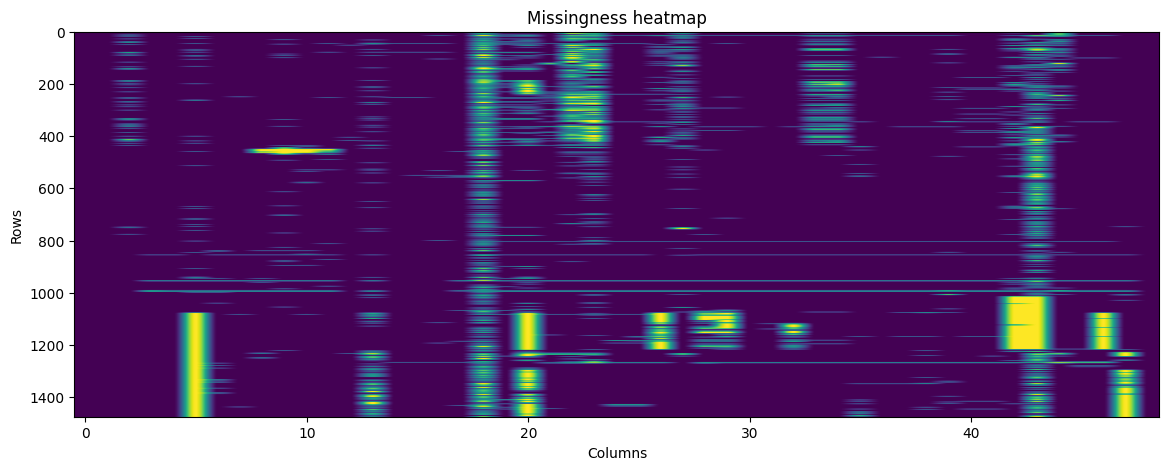


=== CHECK FOR BAD MISSING TOKENS ===
'None': 0
'none': 0
'NONE': 0
'NaN': 0
'nan': 0
'N/A': 0
'NA': 0
'?': 0
' ': 0
' ': 0


In [42]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_parquet("../data/03_primary/mt_patients_validated.parquet")

print("Rows, cols:", df.shape)

# === 1) OVERVIEW ===
display(df.head())

# === 2) Dtypes ===
print("\n=== DTYPES ===")
display(df.dtypes)

# === 3) Missingness per column ===
print("\n=== MISSING VALUES ===")
display(df.isna().sum().sort_values(ascending=False))

# === 4) Check categorical-level sanity ===
categorical_cols = [
    "etiology", "procedure", "anesthesia",
    "ivt_different_hospital", "sex",
    "hemisphere", "occlusion_site"
]

print("\n=== CATEGORY DISTRIBUTIONS (top 15) ===")
for col in categorical_cols:
    if col in df.columns:
        print(f"\nColumn: {col}")
        display(df[col].value_counts(dropna=False).head(15))

# === 5) Check numeric sanity ===
numeric_cols = [
    "age", "aspects", "bmi", "cholesterol",
    "glycemia", "nihss_7d", "mrs90"
]

print("\n=== NUMERIC SUMMARY ===")
display(df[numeric_cols].describe(include="all").T)

# === 6) Show missingness heatmap ===
plt.figure(figsize=(14,5))
plt.imshow(df.isna(), aspect='auto', cmap='viridis')
plt.title("Missingness heatmap")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.show()

# === 7) Check for leftover forbidden missing tokens ===
bad_tokens = ["None","none","NONE","NaN","nan","N/A","NA","?"," ", " "]

print("\n=== CHECK FOR BAD MISSING TOKENS ===")
for tok in bad_tokens:
    count = (df.astype("string") == tok).sum().sum()
    print(f"{tok!r}: {count}")


In [41]:
import pandas as pd

df = pd.read_parquet("../data/03_primary/mt_patients_validated.parquet")

print("=== DTYPES ===")
print(df.dtypes)

print("\n=== MISSING VALUES ===")
print(df.isna().sum().sort_values(ascending=False))

print("\n=== VALUE COUNTS WITH NA (etiology) ===")
print(df["etiology"].value_counts(dropna=False))

print("\n=== VALUE COUNTS WITH NA (anesthesia) ===")
print(df["anesthesia"].value_counts(dropna=False))


=== DTYPES ===
patient_id                               int64
onset_date                      datetime64[ns]
onset_time                              object
age                                    float64
sex                                     object
aspects                                float64
occlusion_site                          object
hemisphere                              object
procedure                               object
stent_combo                             object
extraction_system                       object
thrombolytics                           object
procedure_duration                     float64
tici                                  category
ivt_given                                 Int8
ivt_different_hospital                  object
transfer_from_other_hospital            object
iat_given                                 Int8
onset_to_ivt_min                       float64
onset_to_puncture_min                  float64
onset_to_recan_min                     float6